In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from financial_analysis import process_all_stocks, calculate_daily_returns, calculate_correlation
from sentiment_analyzer import perform_sentiment_analysis, aggregate_daily_sentiment

In [2]:
STOCK_DATA_DIR = '../data/yfinance_data/Data' 
NEWS_DATA_PATH = '../data/newsData/raw_analyst_ratings.csv'
PROCESSED_NEWS_PATH = '../data/newsData/processed_sentiment_data.csv'

#### Daily Returns Calculation

In [3]:
all_stocks_indicators = process_all_stocks(STOCK_DATA_DIR)

all_returns_list = []
for ticker, df in all_stocks_indicators.items():
    # calculate_daily_returns is responsible for computing daily percentage change in prices
    df_returns = calculate_daily_returns(df)
    all_returns_list.append(df_returns)

all_stocks_returns_df = pd.concat(all_returns_list, ignore_index=True)
print(f"Daily Returns calculated for {len(all_stocks_returns_df['Ticker'].unique())} stocks.")

Processing indicators for AAPL...
Processing indicators for AMZN...
Processing indicators for GOOG...
Processing indicators for META...
Processing indicators for MSFT...
Processing indicators for NVDA...
Daily Returns calculated for 6 stocks.


### Sentiment Analysis and Aggregation

In [4]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kidus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
if os.path.exists(PROCESSED_NEWS_PATH):
    print(f"Loading pre-calculated sentiment data from {PROCESSED_NEWS_PATH}...")
    # Load the saved DataFrame, ensuring 'Date' is parsed correctly
    sentiment_df = pd.read_csv(PROCESSED_NEWS_PATH, parse_dates=['Date'])
    
else:
    print(f"File not found. Beginning sentiment calculation on 1.4M rows...")
    try:
        # Load News Data
        news_df = pd.read_csv(NEWS_DATA_PATH) 

        # Perform Sentiment Analysis
        sentiment_df = perform_sentiment_analysis(news_df)
        
        # Save the result for fast loading next time
        print(f"Calculation complete. Saving processed data to {PROCESSED_NEWS_PATH}...")
        sentiment_df.to_csv(PROCESSED_NEWS_PATH, index=False)

    except LookupError:
        print("\n NLTK Error: The VADER lexicon is missing. Run the download command.")
        sys.exit()

daily_sentiment_df = aggregate_daily_sentiment(sentiment_df)
print("Daily aggregated sentiment scores calculated.")

Loading pre-calculated sentiment data from ../data/newsData/processed_sentiment_data.csv...
Daily aggregated sentiment scores calculated.


### Correlation Analysis

In [7]:
combined_df, correlation_results = calculate_correlation(all_stocks_returns_df, daily_sentiment_df)

print("\nPearson Correlation Results (Sentiment vs. Daily Returns):")
print(correlation_results.to_markdown(index=False))


Pearson Correlation Results (Sentiment vs. Daily Returns):
| Ticker   |   Pearson_Correlation |
|:---------|----------------------:|
| AAPL     |             0.0891563 |
| AMZN     |             0.162847  |
| GOOG     |             0.186945  |
| NVDA     |             0.212913  |


/media/kidus/Local_Disk/Development/1.KAIM/Predicting-news-sentiment-price-movement-/src/financial_analysis.py:118: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_results = combined_df.groupby('Ticker').apply(


#### Visualization for Correlation KPI

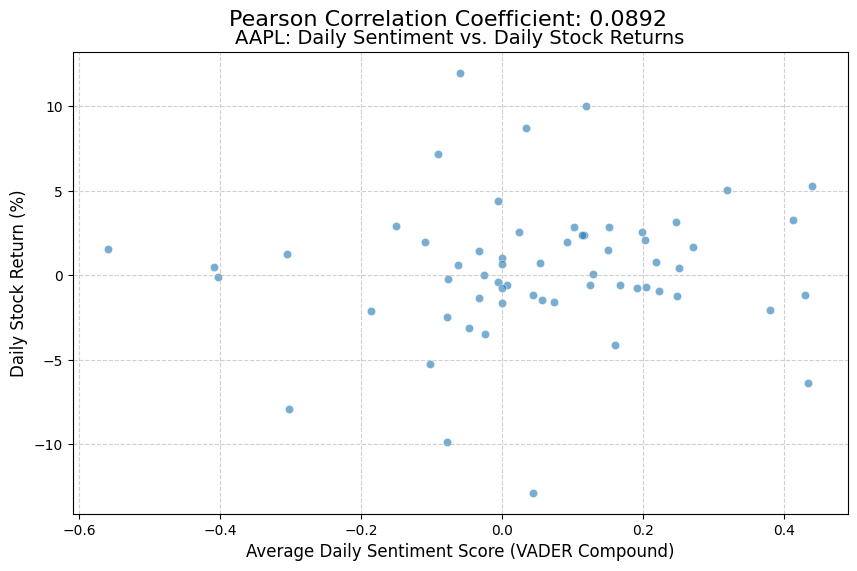

In [9]:
# Choose one stock (e.g., AAPL) for the correlation scatter plot ticker_to_plot = 'AAPL' 
ticker_to_plot = 'AAPL'
aapl_corr_df = combined_df[combined_df['Ticker'] == ticker_to_plot]

plt.figure(figsize=(10, 6))
plt.scatter(aapl_corr_df['avg_daily_sentiment'], aapl_corr_df['Daily_Return'], 
            alpha=0.6, edgecolors='w', linewidth=0.5)

# Add correlation value to the plot
aapl_corr_value = correlation_results[correlation_results['Ticker'] == ticker_to_plot]['Pearson_Correlation'].iloc[0]

plt.title(f'{ticker_to_plot}: Daily Sentiment vs. Daily Stock Returns', fontsize=14)
plt.xlabel('Average Daily Sentiment Score (VADER Compound)', fontsize=12)
plt.ylabel('Daily Stock Return (%)', fontsize=12)
plt.suptitle(f'Pearson Correlation Coefficient: {aapl_corr_value:.4f}', y=0.95, fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('../images/Daily Sentiment vs Daily Stock Returns.png')
plt.show()